In [1]:
# standard library
import os
import json
import glob
import zipfile
from PIL import Image

# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
target_folder = "207 Machine Learning: Final Project"
found_path = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if target_folder in dirs:
        found_path = os.path.join(root, target_folder)
        break

if found_path:
    os.chdir(found_path)
    print("Changed working directory to:", os.getcwd())
else:
    print(f"Folder '{target_folder}' not found.")

Changed working directory to: /content/drive/.shortcut-targets-by-id/1MnqFmQYij3NcmwhbYUVc-9h4Dp6eLuMH/207 Machine Learning: Final Project


In [4]:
data_dir = "./Data (1)/"

# Read in the data
centroids_data = pd.read_csv(os.path.join(data_dir, "Regional_combined_centroids_YL.csv"))
# centroids_data.drop(columns=['state'], inplace=True)

# Rename the columns
with open(os.path.join(data_dir, "rename.json"), 'r') as f:
    rename = json.load(f)

rename_dict = {}
for col in centroids_data.columns:
    if col in rename.keys():
         rename_dict[col] = rename[col]['simplifiedName']

centroids_data.rename(columns=rename_dict, inplace=True)

# Make sure the TractID column is properly converted to string type
centroids_data['TractID'] = centroids_data['TractID'].astype(str).str.zfill(11)

# Pad 10-digit GEOIDs to 11-digit strings
centroids_data['GEOID'] = centroids_data['GEOID'].astype(str).str.zfill(11)


# Exploratory Data Analysis

### <span style="color:chocolate">1. Check Overall Data Cleanliness</span>

In [5]:
# Check for missing values
print(centroids_data.isnull().sum().sort_values(ascending=False).to_string())

TractID                       0
BlackPopulation               0
LAPop_10Miles                 0
LAPopShare_10Miles            0
LALowIncome_10Miles           0
LALowIncomeShare_10Miles      0
LANoVehicle_10Miles           0
LANoVehicleShare_10Miles      0
LASNAP_10Miles                0
LASNAPShare_10Miles           0
LowIncomePopulation           0
ChildPopulation               0
SeniorPopulation              0
WhitePopulation               0
AsianPopulation               0
LASNAP_1Mile                  0
NHPIPopulation                0
AIANPopulation                0
MultiracialPopulation         0
HispanicPopulation            0
NoVehicleHouseholds           0
SNAPRecipients                0
STATEFP                       0
GEOID                         0
geometry                      0
centroid                      0
latitude                      0
longitude                     0
LASNAPShare_1Mile             0
LANoVehicleShare_1Mile        0
StateName                     0
IsLowInc

We do not have records for District of Columbia and Delaware

In [8]:
# Our analysis covers 8 US southern states
centroids_data['StateName'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [9]:
# Each row represents a unique tract
centroids_data['TractID'].nunique() == centroids_data['TractID'].count()

True

In [10]:
# Make sure the definition of LILA are consistent
# LILA_Urban1_Rural10 is defined as LA_Urban1_Rural10 & IsLowIncome
sum(centroids_data['LILA_Urban1_Rural10']) == sum(centroids_data['LA_Urban1_Rural10'] & centroids_data['IsLowIncome'])

True

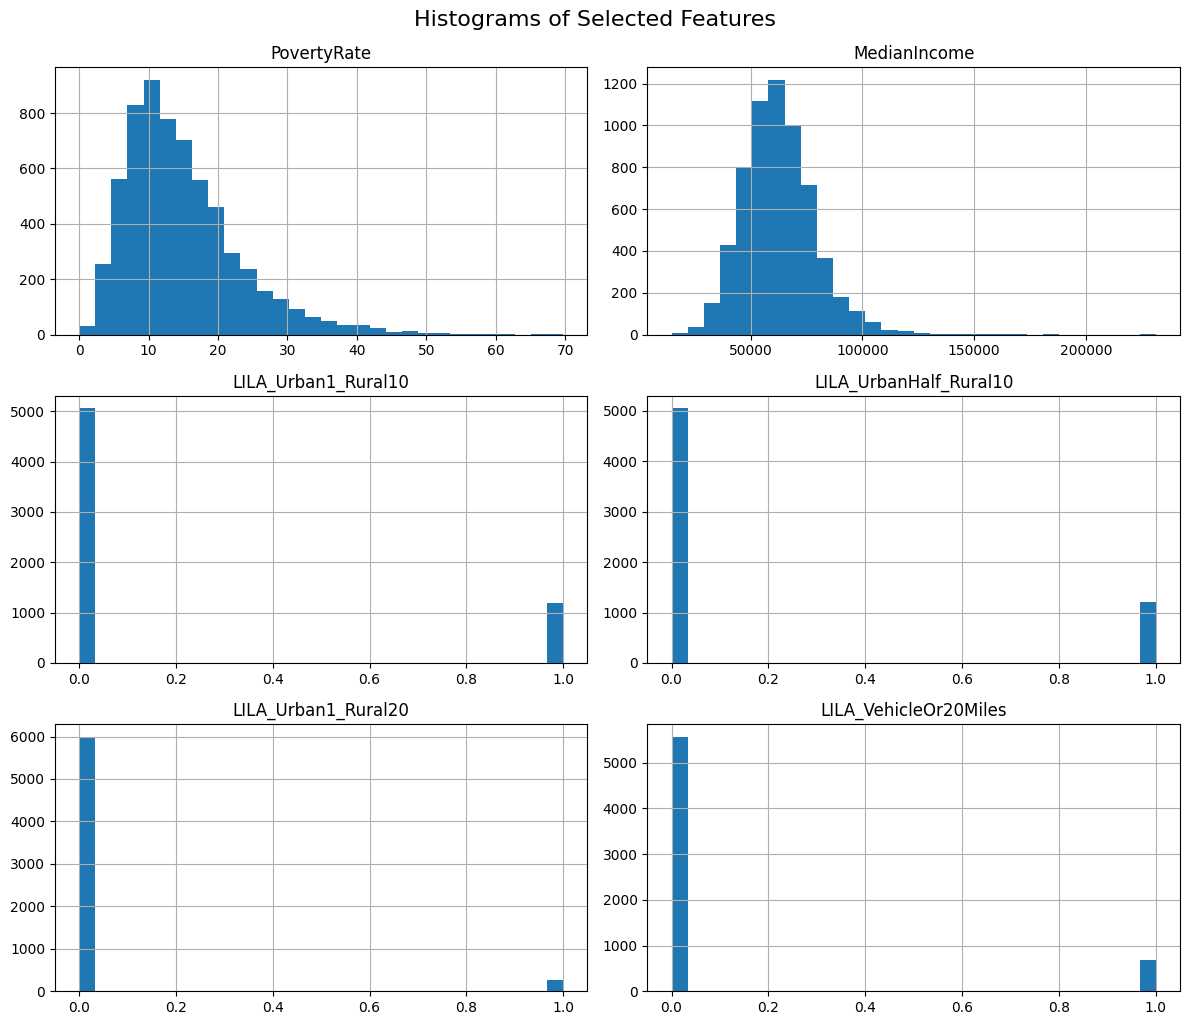

In [11]:
# Histogram of sample selected columns
columns_of_interest = [
    "PovertyRate",
    "MedianIncome",
    "LILA_Urban1_Rural10",
    "LILA_UrbanHalf_Rural10",
    "LILA_Urban1_Rural20",
    "LILA_VehicleOr20Miles",
]


centroids_data[columns_of_interest].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.suptitle("Histograms of Selected Features", fontsize=16, y=1.02)
plt.show()


### <span style="color:chocolate">2. Definition of Food Desert</span>
- According to [USDA's definitions of food desert](https://extension.unr.edu/publication.aspx?PubID=2484), a food desert tract needs to satisfy two requirement:
    - Low Income Community:
        - `IsLowIncome` = 1
    - Low Access Community:
        - `LA_Urban1_Rural10` = 1
        - Note: There is an additional definition regarding transportation: \>=100 households are more than 0.5 mile from a supermarket and no vehicle access, or >= 500 people or 33% population live >=20% from a supermarket
        - 'LA_VehicleOr20Miles` = 1

We define a food desert:
- `LILA_Urban1_Rural10` = 1


In [12]:
# Define a function to classify tracts as food deserts
def is_food_desert(row):
    return 1 if (row["LILA_Urban1_Rural10"] == 1) else 0

- Option 2: `IsLowIncome` = 1 & (`LILA_Urban1_Rural10` = 1 or `LILA_VehicleOr20Miles` = 1)

In [13]:
# Define a function to classify tracts as food deserts
def is_food_desert_2(row):
    is_low_income = row["IsLowIncome"] == 1
    is_low_access = False

    if row["IsUrban"] == 1:
        # Urban area: > 1 mile
        is_low_access = (
            row["LILA_Urban1_Rural10"] == 1 or
            row["LILA_UrbanHalf_Rural10"] == 1
        )
    else:
        # Rural area: > 10 miles
        is_low_access = row["LILA_Urban1_Rural10"] == 1

    # Optional vehicle or 20-mile access issue
    if row["LILA_VehicleOr20Miles"] == 1:
        is_low_access = True

    return 1 if is_low_income and is_low_access else 0

For simplicity sake, we use **Option 1** for our food desert definition

In [14]:
# Create a new column in the DataFrame to indicate food deserts
centroids_data["IsFoodDesert"] = centroids_data.apply(is_food_desert, axis=1)
centroids_data.head()

,TractID,StateName,CountyName,IsUrban,Pop2010,OccupiedHousingUnits,HighGroupQuarters,GroupQuartersPopulation,GroupQuartersShare,LILA_Urban1_Rural10,...,NoVehicleHouseholds,SNAPRecipients,STATEFP,GEOID,geometry,centroid,latitude,longitude,ImagePath,IsFoodDesert
0,01001020801,Alabama,Autauga County,0,3081,1074,0,0.0,0.00,0,...,68.0,143.0,1,01001020801,POLYGON ((-86.59549799999999 32.38112299999999...,POINT (-86.52599860489222 32.41334358601727),32.413344,-86.525999,./Data (1)/Pictures/All/Alabama/0_01001020801.jpg,0
1,01001021000,Alabama,Autauga County,0,2894,1085,0,10.0,0.35,1,...,9.0,146.0,1,01001021000,"POLYGON ((-86.92123699999999 32.65708, -86.921...",POINT (-86.7563118951911 32.60893537926207),32.608935,-86.756312,./Data (1)/Pictures/All/Alabama/1_01001021000.jpg,1
2,01001021100,Alabama,Autauga County,0,3320,1306,0,33.0,0.99,1,...,269.0,230.0,1,01001021100,"POLYGON ((-86.90675 32.537298, -86.90650099999...",POINT (-86.73220673302137 32.4560217849141),32.456022,-86.732207,./Data (1)/Pictures/All/Alabama/1_01001021100.jpg,1
3,01003010100,Alabama,Baldwin County,0,3804,1510,0,31.0,0.81,1,...,84.0,126.0,1,01003010100,"POLYGON ((-87.97691999999999 31.086581, -87.97...",POINT (-87.78621626953058 31.112769435638448),31.112769,-87.786216,./Data (1)/Pictures/All/Alabama/1_01003010100.jpg,1
4,01003010200,Alabama,Baldwin County,0,2902,1111,0,6.0,0.21,0,...,91.0,146.0,1,01003010200,"POLYGON ((-87.822516 30.953785999999997, -87.8...",POINT (-87.68169986361153 30.94276433343275),30.942764,-87.681700,./Data (1)/Pictures/All/Alabama/0_01003010200.jpg,0


### <span style="color:chocolate">3. Description of Variables</span>


In [15]:
# Percentage of tracts contributed by each state
state_contribution = centroids_data["StateName"].value_counts(normalize=True).rename("% of Total").round(3)
state_contribution

Texas             0.079
Illinois          0.041
Iowa              0.040
Minnesota         0.038
Missouri          0.036
California        0.036
Georgia           0.036
Oklahoma          0.034
Kentucky          0.032
Alabama           0.031
Wisconsin         0.030
Tennessee         0.029
Arkansas          0.028
Kansas            0.026
Virginia          0.025
Michigan          0.025
Indiana           0.024
Nebraska          0.023
Louisiana         0.023
Florida           0.022
Mississippi       0.022
North Carolina    0.021
Colorado          0.021
Arizona           0.019
Washington        0.019
Oregon            0.019
Montana           0.019
South Carolina    0.018
Pennsylvania      0.018
New York          0.018
Ohio              0.018
West Virginia     0.016
North Dakota      0.015
South Dakota      0.015
New Mexico        0.014
Idaho             0.013
Maine             0.012
Alaska            0.009
Utah              0.009
Nevada            0.007
Wyoming           0.006
Vermont         

- Tennessee and Georgia are the two states with most centroids.
- Arkansas and Mississippi may not be accurately captured in our development

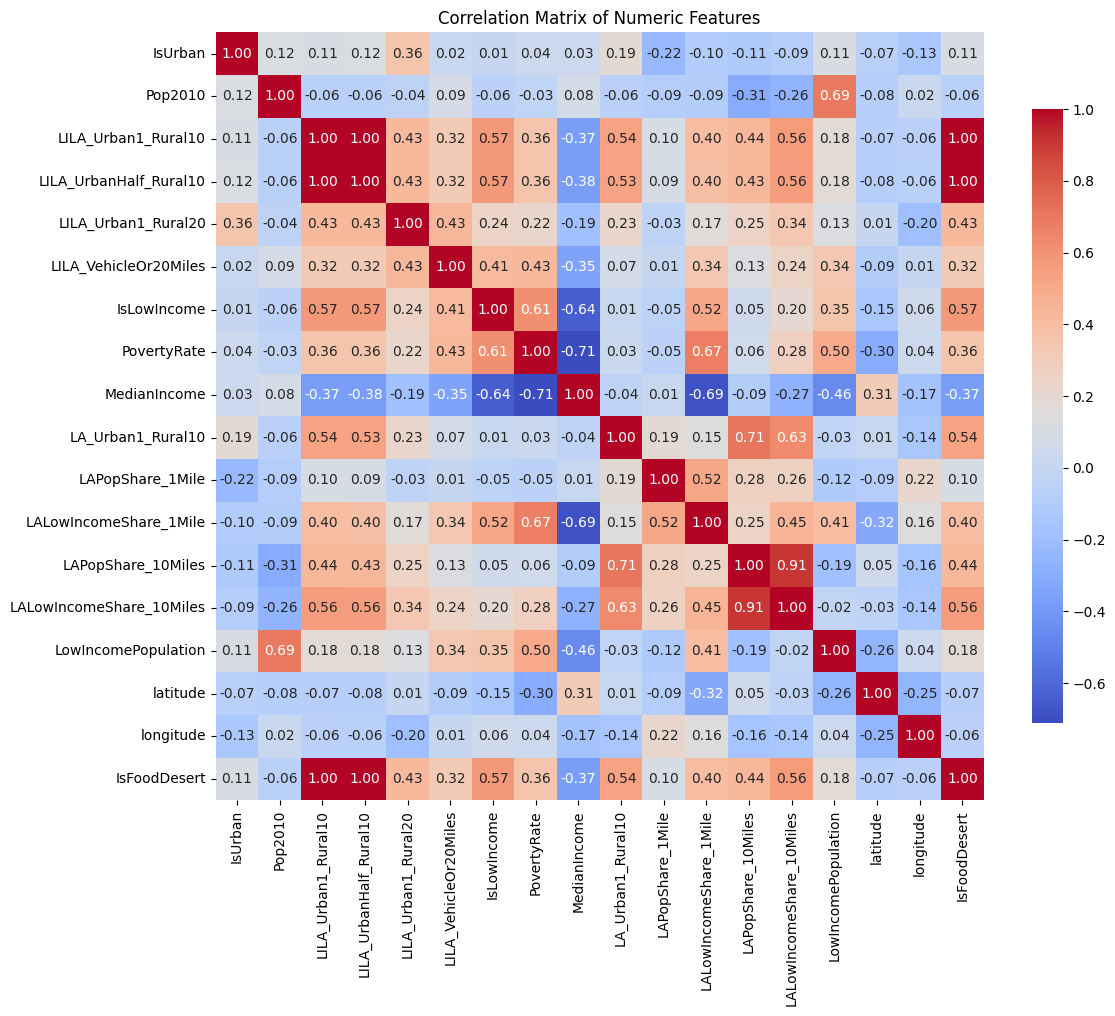

In [16]:
# Correlation Heatmap
cols = ["TractID",
    "StateName",
    "CountyName",
    "IsUrban",
    "Pop2010",
    "LILA_Urban1_Rural10",
    "LILA_UrbanHalf_Rural10",
    "LILA_Urban1_Rural20",
    "LILA_VehicleOr20Miles",
    "IsLowIncome",
    "PovertyRate",
    "MedianIncome",
    "LA_Urban1_Rural10",
    "LAPopShare_1Mile",
    "LALowIncomeShare_1Mile",
    "LAPopShare_10Miles",
    "LALowIncomeShare_10Miles",
    "LowIncomePopulation",
    "GEOID",
    "latitude",
    "longitude",
    "IsFoodDesert"]
numeric_cols_df = centroids_data[cols].select_dtypes(include=['float64', 'int64'])
corr = numeric_cols_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

In [17]:
# Distribution of Food Desert
count_df = centroids_data.groupby(["LILA_Urban1_Rural10", "IsFoodDesert"]).size().reset_index(name="Count")
total_count = count_df["Count"].sum()
count_df["Percentage"] = count_df["Count"] / total_count * 100
count_df["IsFoodDesert"] = count_df["IsFoodDesert"].map({0: "Not Food Desert", 1: "Food Desert"})
count_df


,LILA_Urban1_Rural10,IsFoodDesert,Count,Percentage
0,0,Not Food Desert,5057,80.873181
1,1,Food Desert,1196,19.126819


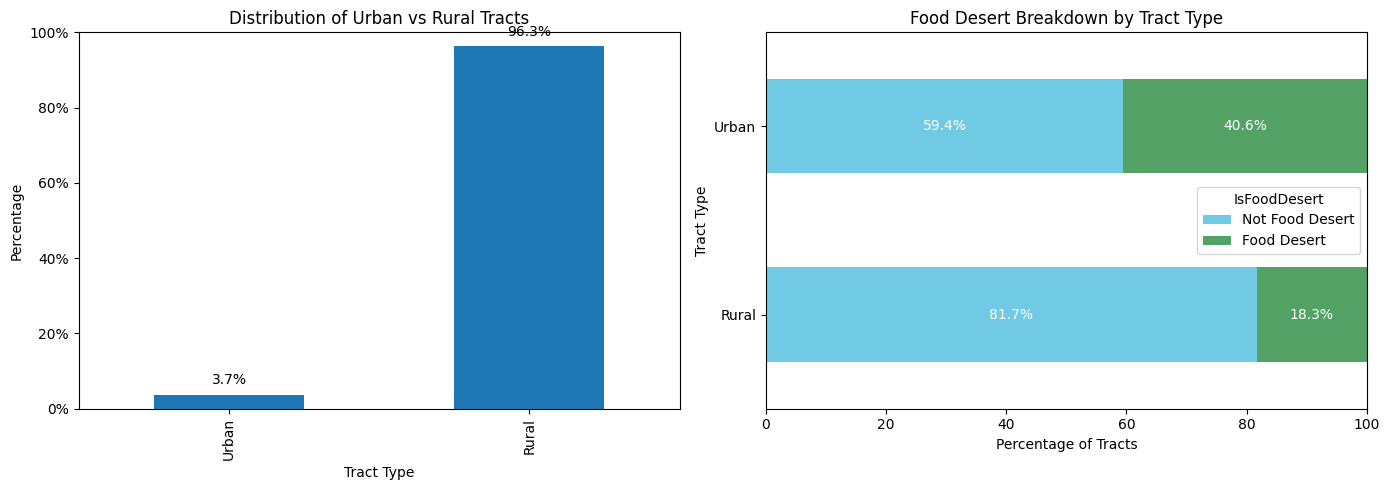

In [18]:
# Plotting the distribution of Urban vs Rural tracts and the food desert breakdown

# === First chart: Distribution of Urban vs Rural Tracts ===
urban_counts = centroids_data["IsUrban"].value_counts(normalize=True).reset_index().sort_values(by="IsUrban", ascending=True)
urban_counts.columns = ["IsUrban", "Percentage"]
label_map = {0: "Rural", 1: "Urban"}
urban_counts["Label"] = urban_counts["IsUrban"].map(label_map)
urban_counts.set_index("Label", inplace=True)

# === Second chart: Stacked food desert percentage ===
ct = pd.crosstab(centroids_data["IsUrban"], centroids_data["IsFoodDesert"], normalize='index') * 100
ct.index = ct.index.map({0: "Rural", 1: "Urban"})
ct.columns = ct.columns.map({0: "Not Food Desert", 1: "Food Desert"})

# === Create subplots ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left subplot: Bar chart of tract type distribution ---
ax1 = axes[0]
urban_counts["Percentage"].plot(
    kind="bar",
    ax=ax1,
    ylim=(0, 1)
)

ax1.set_title("Distribution of Urban vs Rural Tracts")
ax1.set_xlabel("Tract Type")
ax1.set_ylabel("Percentage")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Add labels on bars
for i, pct in enumerate(urban_counts["Percentage"]):
    ax1.text(i, pct + 0.02, f"{pct:.1%}", ha='center', va='bottom', fontsize=10)

# --- Right subplot: Stacked horizontal bar chart ---
ax2 = axes[1]
ct.plot(kind='barh',
        stacked=True,
        ax=ax2,
        color=["#71cae3", "#54a166"],
        legend=True)

ax2.set_title("Food Desert Breakdown by Tract Type")
ax2.set_xlabel("Percentage of Tracts")
ax2.set_ylabel("Tract Type")
ax2.set_xlim(0, 100)

# Add percent labels inside bars
for i, (idx, row) in enumerate(ct.iterrows()):
    x_start = 0
    for label, value in row.items():
        if value > 2:
            ax2.text(x_start + value / 2, i, f"{value:.1f}%", ha='center', va='center', color='white', fontsize=10)
        x_start += value

# Final formatting
plt.tight_layout()
plt.show()


60% of the tracts are urban. And, a larger proportion of Food Desert Tracts is found in urban areas.

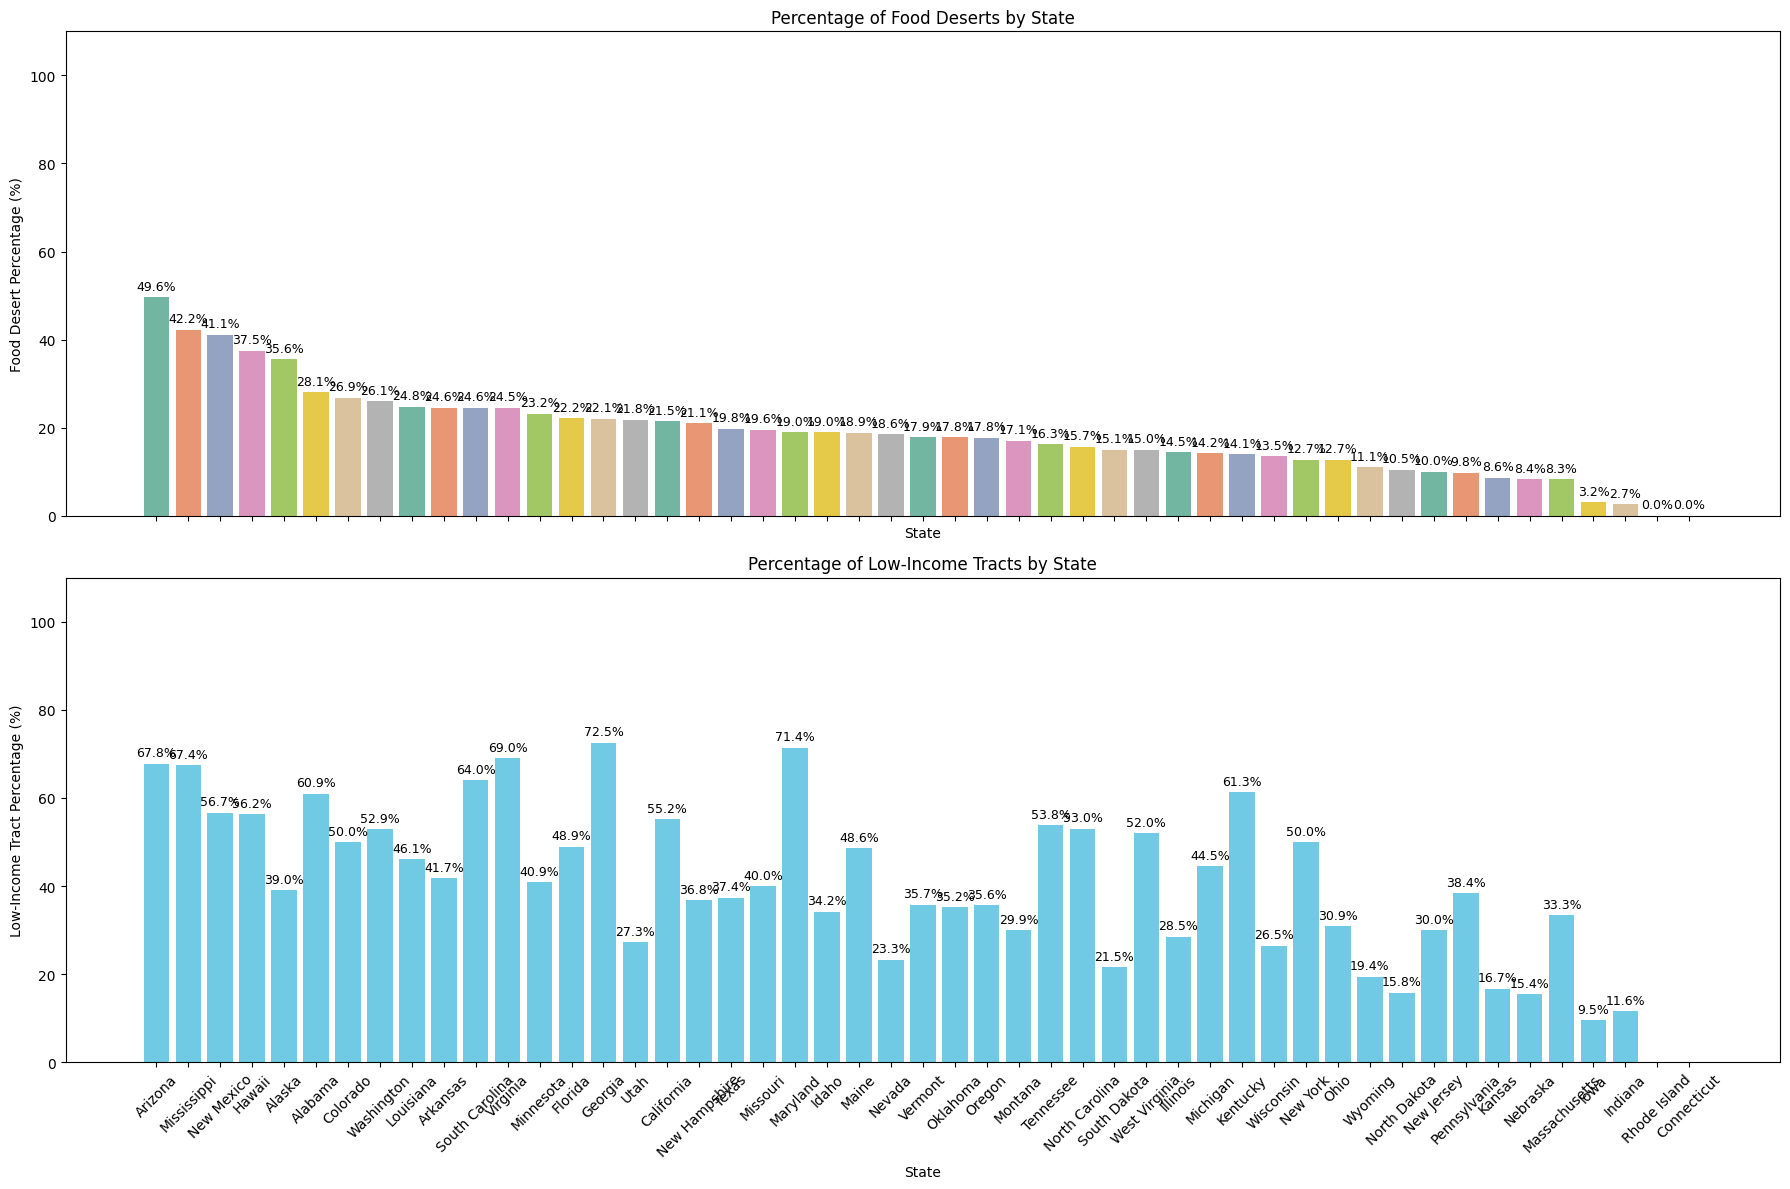

In [20]:
# Plotting Food Desert and Low-Income Tract Percentages by State

# --- Food Desert Count by State ---
pct_state = centroids_data[['StateName', 'IsFoodDesert']] \
    .groupby('StateName').sum() \
    .sort_values(by='IsFoodDesert', ascending=False) \
    .reset_index()
pct_state['Percentage'] = pct_state['IsFoodDesert'] * 100

# --- Food Desert Percentage by State ---
pct_state = centroids_data[['StateName', 'IsFoodDesert']] \
    .groupby('StateName').mean() \
    .sort_values(by='IsFoodDesert', ascending=False) \
    .reset_index()
pct_state['Percentage'] = pct_state['IsFoodDesert'] * 100

# --- Low-Income Tract Percentage by State ---
low_income_pct = (
    centroids_data.groupby("StateName")["IsLowIncome"]
    .mean()
    .sort_values(ascending=False)
    * 100
)
low_income_df = low_income_pct.reset_index()
low_income_df.columns = ["StateName", "Percentage"]

# --- Align state order for consistent comparison (optional) ---
state_order = pct_state["StateName"].tolist()
low_income_df = low_income_df.set_index("StateName").reindex(state_order).reset_index()

# --- Create side-by-side subplots ---
fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Plot Food Desert %
sns.barplot(data=pct_state, x='StateName', y='Percentage', palette='Set2', ax=axes[0])
axes[0].set_title("Percentage of Food Deserts by State")
axes[0].set_xlabel("State")
axes[0].set_ylabel("Food Desert Percentage (%)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 110)
for i, row in pct_state.iterrows():
    axes[0].text(i, row['Percentage'] + 1, f"{row['Percentage']:.1f}%",
                 ha='center', va='bottom', fontsize=9)

# Plot Low-Income Tract %
bars = axes[1].bar(low_income_df["StateName"], low_income_df["Percentage"], color="#71cae3")
axes[1].set_title("Percentage of Low-Income Tracts by State")
axes[1].set_xlabel("State")
axes[1].set_ylabel("Low-Income Tract Percentage (%)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, 110)
for bar in bars:
    height = bar.get_height()
    if height > 1:
        axes[1].text(bar.get_x() + bar.get_width() / 2, height + 1,
                     f"{height:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


It looks like constructing new stores in Arkansas could help resolve the food desert issue, as the lack of grocery store development appears to be a more significant factor than the poverty rate.

### <span style="color:chocolate">4. Geospatial Analysis</span>

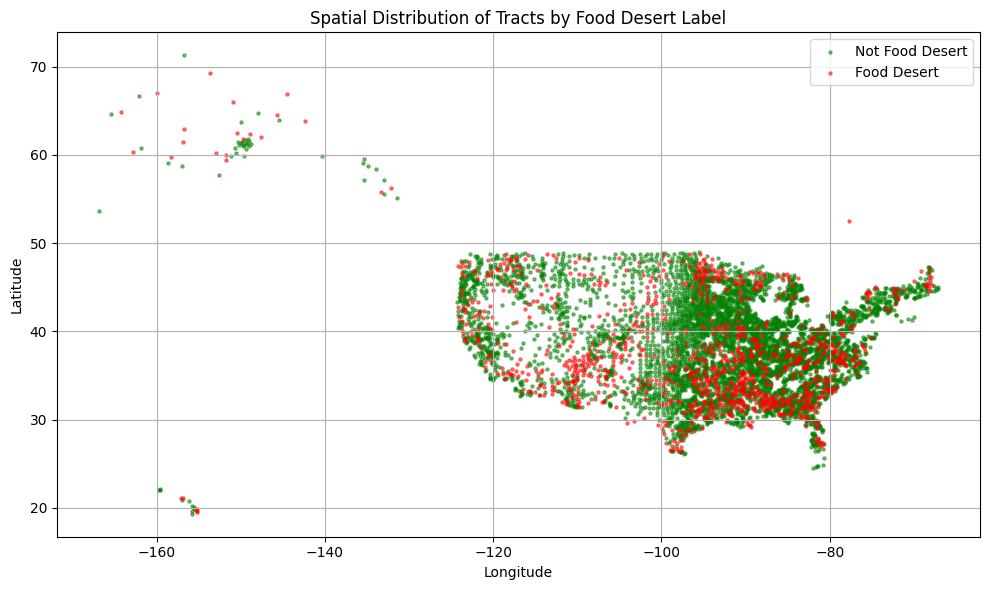

In [21]:
plt.figure(figsize=(10, 6))

colors = {0: "green", 1: "red"}
labels = {0: "Not Food Desert", 1: "Food Desert"}

for label_val in [0, 1]:
    subset = centroids_data[centroids_data["LILA_Urban1_Rural10"] == label_val]
    plt.scatter(subset["longitude"], subset["latitude"],
                s=5, c=colors[label_val], label=labels[label_val], alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Tracts by Food Desert Label")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- It looks like food deserts tend to be clustered together in groups. and in this scatterplot, they are more concentrated in the west.
- It also looks like food deserts sort of surround cities?

In [ ]:
import plotly.express as px

# 1. Load shapefile (GeoDataFrame)
tracts_gdf = gpd.read_file(os.path.join(data_dir, "cb_2020_us_tract_500k/cb_2020_us_tract_500k.shp"))

# 2. Ensure matching key types
tracts_gdf['GEOID'] = tracts_gdf['GEOID'].astype(str)
centroids_data['TractID'] = centroids_data['TractID'].astype(str)

# 3. Merge with food desert info
merged_gdf = tracts_gdf.merge(
    centroids_data[['TractID', 'IsFoodDesert', 'StateName', 'CountyName']],
    left_on='GEOID',
    right_on='TractID',
    how='inner'
)

# 4. Label food desert status
merged_gdf['FoodDesertStatus'] = merged_gdf['IsFoodDesert'].map({
    1: 'Food Desert',
    0: 'Not a Food Desert'
})

# 5. Convert CRS to WGS84 for Plotly
merged_gdf = merged_gdf.to_crs(epsg=4326)

# 6. Prepare GeoJSON for Plotly
geojson_data = merged_gdf.__geo_interface__

# 7. Plotly choropleth
fig = px.choropleth_mapbox(
    merged_gdf,
    geojson=geojson_data,
    locations=merged_gdf.index,
    color='FoodDesertStatus',
    color_discrete_map={
        'Food Desert': '#e6550d',
        'Not a Food Desert': '#a1d99b'
    },
    hover_data={
        'GEOID': True,
        'StateName': True,
        'CountyName': True,
        'FoodDesertStatus': True
    },
    mapbox_style='carto-positron',
    center={'lat': 37.8, 'lon': -96},
    zoom=3,
    opacity=0.65
)

fig.update_layout(
    title='Food Desert Status by Census Tract',
    margin={'r': 0, 't': 40, 'l': 0, 'b': 0},
    height=700
)

fig.show()


In [ ]:
# 1. Load shapefile (GeoDataFrame)
tracts_gdf = gpd.read_file(os.path.join(data_dir, "cb_2020_us_tract_500k/cb_2020_us_tract_500k.shp"))

# 2. Ensure matching keys and string types
tracts_gdf['GEOID'] = tracts_gdf['GEOID'].astype(str)
centroids_data['TractID'] = centroids_data['TractID'].astype(str)

# 3. Merge with additional columns (StateName, CountyName, IsUrban)
merged_gdf = tracts_gdf.merge(
    centroids_data[['TractID', 'IsUrban', 'StateName', 'CountyName']],
    left_on='GEOID',
    right_on='TractID',
    how='inner'
)

# 4. Color map for urban/rural
color_map = {
    0: '#71cae3',  # rural
    1: '#54a166',  # urban
}
merged_gdf['UrbanType'] = merged_gdf['IsUrban'].map({0: 'Rural', 1: 'Urban'})

# 5. Convert CRS and to GeoJSON
merged_gdf = merged_gdf.to_crs(epsg=4326)
geojson_data = merged_gdf.__geo_interface__

# 6. Plotly choropleth with state/county in hover
fig = px.choropleth_mapbox(
    merged_gdf,
    geojson=geojson_data,
    locations=merged_gdf.index,
    color="UrbanType",
    color_discrete_map={'Rural': '#71cae3', 'Urban': '#54a166'},
    hover_data={
        "GEOID": True,
        "StateName": True,
        "CountyName": True,
        "UrbanType": True
    },
    mapbox_style="carto-positron",
    center={"lat": 37.8, "lon": -96},
    zoom=3,
    opacity=0.6
)

fig.update_layout(title="Urban vs Rural Census Tracts (with State and County Info)", margin={"r":0,"t":40,"l":0,"b":0})
fig.show()


### <span style="color:chocolate">5: Image Files</span>
- Do we have images for each tract/row?

In [30]:
!unzip "Data/Pictures/Alabama/Alabama.zip" -d "Data/Pictures/Alabama"


Archive:  Data/Pictures/Alabama/Alabama.zip
replace Data/Pictures/Alabama/0_1001020300.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/Pictures/Alabama/0_1001020400.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/Pictures/Alabama/0_1001020801.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [31]:
!ls "Data/Pictures/Alabama"

0_1001020100.jpg  0_1069042000.jpg  0_1097005100.jpg  1_1001020700.jpg
0_1001020300.jpg  0_1069042100.jpg  0_1097005200.jpg  1_1001021000.jpg
0_1001020400.jpg  0_1071950500.jpg  0_1097005400.jpg  1_1001021100.jpg
0_1001020801.jpg  0_1071950700.jpg  0_1097005500.jpg  1_1003010100.jpg
0_1003010200.jpg  0_1071951000.jpg  0_1097005800.jpg  1_1003010600.jpg
0_1003010300.jpg  0_1073001902.jpg  0_1097005900.jpg  1_1003010906.jpg
0_1003010400.jpg  0_1073002000.jpg  0_1097006000.jpg  1_1005950100.jpg
0_1003010500.jpg  0_1073002200.jpg  0_1097006102.jpg  1_1005950300.jpg
0_1003010704.jpg  0_1073002303.jpg  0_1097006103.jpg  1_1005950400.jpg
0_1003010800.jpg  0_1073002305.jpg  0_1097006104.jpg  1_1005950800.jpg
0_1003010903.jpg  0_1073002306.jpg  0_1097006402.jpg  1_1011952100.jpg
0_1003010904.jpg  0_1073003200.jpg  0_1097006403.jpg  1_1013953000.jpg
0_1003011000.jpg  0_1073003300.jpg  0_1097006407.jpg  1_1013953100.jpg
0_1003011102.jpg  0_1073003400.jpg  0_1097006501.jpg  1_1013953200.jpg
0_1003

In [32]:
#unzip all the images
base_path = "Data/Pictures"

for state_folder in os.listdir(base_path):
    state_path = os.path.join(base_path, state_folder)
    if os.path.isdir(state_path):
        for file in os.listdir(state_path):
            if file.endswith(".zip"):
                zip_path = os.path.join(state_path, file)
                print(f"Unzipping {zip_path}...")
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(state_path)


Unzipping Data/Pictures/Arkansas/Arkansas.zip...
Unzipping Data/Pictures/Louisiana/Louisiana.zip...
Unzipping Data/Pictures/Mississippi/Mississippi.zip...
Unzipping Data/Pictures/Tennessee/Tennesee.zip...
Unzipping Data/Pictures/Kentucky/Kentucky.zip...
Unzipping Data/Pictures/South Carolina/South_Carolina.zip...
Unzipping Data/Pictures/Georgia/Georgia.zip...
Unzipping Data/Pictures/Alabama/Alabama.zip...


In [33]:
image_dir = "Data/Pictures"
image_files = glob.glob(f"{image_dir}/**/*.jpg", recursive=True)

print(f"Total images found: {len(image_files)}")

Total images found: 7124


- Do image labels make sense?

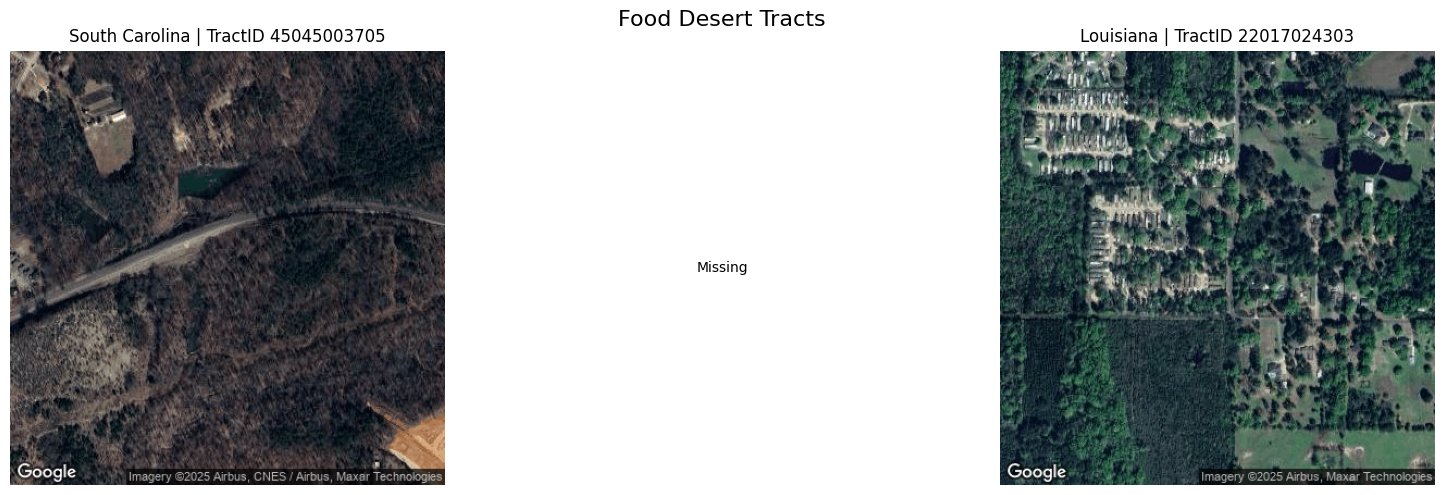

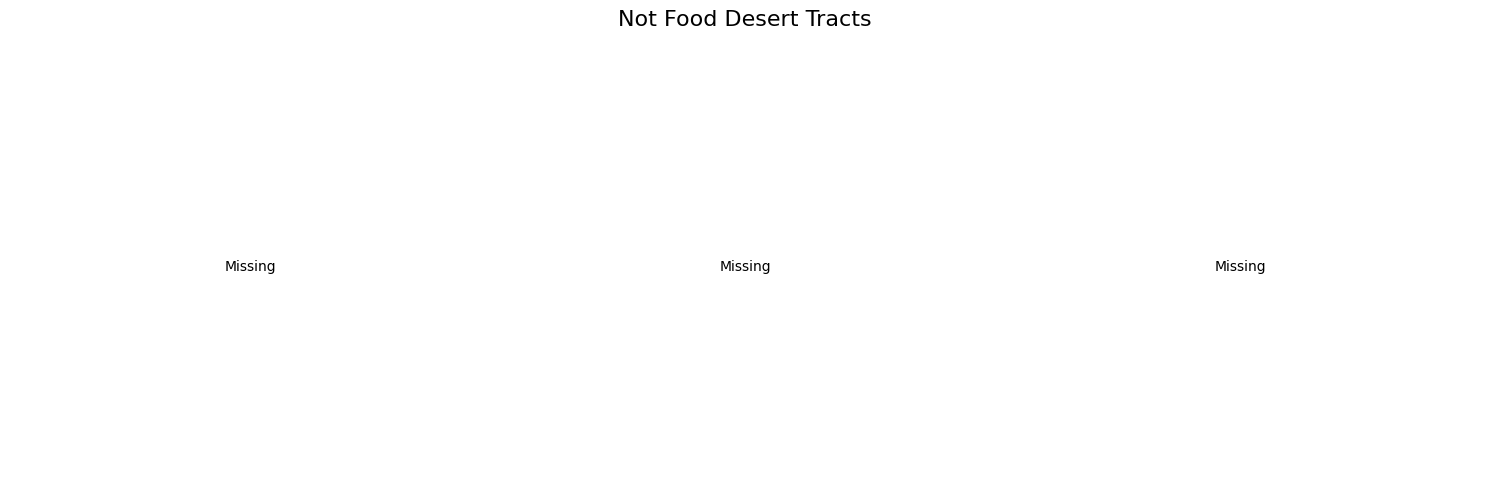

In [38]:
base_path = "Data/Pictures"

# Filter by food desert or not
food_desert = centroids_data[centroids_data["LILA_Urban1_Rural10"] == 1]
non_food_desert = centroids_data[centroids_data["LILA_Urban1_Rural10"] == 0]

def show_examples(df, label, n=3):
    samples = df.sample(n)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    fig.suptitle(f"{label} Tracts", fontsize=16)

    for i, (_, row) in enumerate(samples.iterrows()):
        tract = str(row["TractID"])
        label_val = int(row["LILA_Urban1_Rural10"])
        state = row["StateName"] if "StateName" in row else row["StateName"]
        img_name = f"{label_val}_{tract}.jpg"
        img_path = os.path.join(base_path, state, img_name)

        if os.path.exists(img_path):
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(f"{state} | TractID {tract}")
        else:
            axs[i].text(0.5, 0.5, 'Missing', ha='center', va='center')
            axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# inspect
show_examples(food_desert, "Food Desert")
show_examples(non_food_desert, "Not Food Desert")

Not going to lie....i dont think these all visually check out

- Check out Image Sizing

In [39]:
image_root = "Data/Pictures"

#get every image
image_paths = []
for root, dirs, files in os.walk(image_root):
    for file in files:
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(root, file))

#create function to get dimensions
def get_dims(file):
    try:
        im = Image.open(file)
        arr = np.array(im)
        #return the height, width, and channels
        return arr.shape
    except:
        return None

# sample
dims = [get_dims(p) for p in image_paths[:500]]
dims = [d for d in dims if d is not None]

# Count dimension frequencies
from collections import Counter
Counter(dims)


Counter({(400, 400): 500})

Next Steps:
-resize images and normalize pixel values (like in the last homework)

[link text](https://)

In [40]:
centroids_data.head()

,TractID,StateName,CountyName,IsUrban,Pop2010,OccupiedHousingUnits,HighGroupQuarters,GroupQuartersPopulation,GroupQuartersShare,LILA_Urban1_Rural10,...,AIANPopulation,MultiracialPopulation,HispanicPopulation,NoVehicleHouseholds,SNAPRecipients,GEOID,latitude,longitude,IsFoodDesert,CountyFIPS
0,13001950100,Georgia,Appling County,0,3190,1270,0,34,1.07,0,...,5,86,104,68,164,13001950100,31.878017,-82.270221,0,13001
1,13001950400,Georgia,Appling County,0,1476,606,0,0,0.00,1,...,10,46,38,38,96,13001950400,31.665217,-82.190726,1,13001
2,13001950500,Georgia,Appling County,0,3864,1493,0,0,0.00,0,...,36,284,394,49,246,13001950500,31.694233,-82.380489,0,13001
3,13003960100,Georgia,Atkinson County,0,2077,770,0,0,0.00,1,...,18,309,387,67,200,13003960100,31.324885,-83.024239,1,13003
4,13003960200,Georgia,Atkinson County,0,5053,1763,0,20,0.40,0,...,16,1121,1437,124,290,13003960200,31.285147,-82.879234,0,13003


In [41]:
# add one-hot encoding for "StateName" and "IsUrban"
centroids_data = pd.get_dummies(centroids_data,columns = ['StateName','IsUrban'],drop_first = False)
centroids_data.head()

,TractID,CountyName,Pop2010,OccupiedHousingUnits,HighGroupQuarters,GroupQuartersPopulation,GroupQuartersShare,LILA_Urban1_Rural10,LILA_UrbanHalf_Rural10,LILA_Urban1_Rural20,...,StateName_Alabama,StateName_Arkansas,StateName_Georgia,StateName_Kentucky,StateName_Louisiana,StateName_Mississippi,StateName_South Carolina,StateName_Tennessee,IsUrban_0,IsUrban_1
0,13001950100,Appling County,3190,1270,0,34,1.07,0,0,0,...,False,False,True,False,False,False,False,False,True,False
1,13001950400,Appling County,1476,606,0,0,0.00,1,1,0,...,False,False,True,False,False,False,False,False,True,False
2,13001950500,Appling County,3864,1493,0,0,0.00,0,0,0,...,False,False,True,False,False,False,False,False,True,False
3,13003960100,Atkinson County,2077,770,0,0,0.00,1,1,0,...,False,False,True,False,False,False,False,False,True,False
4,13003960200,Atkinson County,5053,1763,0,20,0.40,0,0,0,...,False,False,True,False,False,False,False,False,True,False


In [ ]:
# Train/Temp split (60% train, 40% temp)
train_centroids_data, temp_centroids_data = train_test_split(centroids_data, test_size = 0.4, random_state = 0)
val_controids_data, test_controids_data = train_test_split(temp_centroids_data, test_size = 0.5, random_state = 0)

print("train_centroids_data shape:",train_centroids_data.shape,"val_centroids_data shape:",val_controids_data.shape,"test_centroids_data shape:",test_controids_data.shape)

train_centroids_data shape: (4272, 160) val_centroids_data shape: (1424, 160) test_centroids_data shape: (1425, 160)
